In [1]:
from mongo_connection import Mongo_connection
import numpy as np
import pandas as pd
import itertools
import pair_transition_analysis
import granger_causation_test
from matplotlib import pyplot as plt
from collections import defaultdict
import roi_config
import fixation
import hypothesis_testing
import bulk_run
import anova
import re
import utils

[INFO] Created a mongodb instance.
[INFO] Currently connected to eye_tracking_db/fixation_sequences.
[INFO] Found 50 documents.


In [2]:
mongo = Mongo_connection()
mongo.connect()

[INFO] Created a mongodb instance.
[INFO] Currently connected to eye_tracking_db/fixation_sequences.
[INFO] Found 50 documents.


In [3]:
documents = mongo.find({})
document = documents[15]
print("trial: {}, group: {}, pID: {}".format(document["trial"], document["group"], document["pID"]))

d_data = document["data"]
df_data = pd.DataFrame(d_data)
df_data = fixation.merge_consecutive_fixations_in_same_roi(df_data)
transitions, L = pair_transition_analysis.encode_transition(df_data["roi"], "fix")

trial: 1, group: 2, pID: 020


In [73]:
transitions

'XZAZAXSZXAXSZXZAXAZXAXZXAZXZXZXAZSXSXSXAXZAXZASZAZXZAZSZAXZAXSXAXAXZXAXSXAXZXZAXSZAZXZASXSAXAXAXSXZXSX'

In [98]:
def find_pos(ch, s):
    return [m.start() for m in re.finditer(ch, s)]

def create_first_order_transition_matrix(sequence):
    d = {}
    for c in sequence:
        if c in list(d.keys()):
            continue
        d_char = defaultdict(int)
        list_char_pos = find_pos(c, sequence)
        for pos in list_char_pos:
            if pos == len(sequence) - 1: # reach the end of the string
                continue
            next_char = sequence[pos + 1]
            d_char[next_char] += 1
        d[c] = d_char

    df_count = pd.DataFrame(d).reindex(columns=["A", "S", "X", "Z"]).sort_index().fillna(0)
    df_prob = df_count/df_count.sum(axis = 0)
    
    return df_count, df_prob

In [99]:
create_first_order_transition_matrix(transitions)

(      A    S     X     Z
 A   0.0  1.0  12.0  12.0
 S   2.0  0.0  10.0   2.0
 X  16.0  8.0   0.0  12.0
 Z   7.0  5.0  14.0   0.0,
       A         S         X         Z
 A  0.00  0.071429  0.333333  0.461538
 S  0.08  0.000000  0.277778  0.076923
 X  0.64  0.571429  0.000000  0.461538
 Z  0.28  0.357143  0.388889  0.000000)

In [68]:
def create_empty_matrix():
    permutations = list(itertools.product("ASXZ", repeat=3))
    good_permutations = []
    for c in permutations:
        if c[0] == c[1] or c[1] == c[2]:
            continue
        good_permutations.append(c)
        
    d = defaultdict(dict)
    for perm in good_permutations:
        first_2gram_transition = perm[0] + perm[1]
        d[first_2gram_transition][perm[2]] = 0
        
    return d

In [148]:
def create_second_order_transition_matrix(sequence):
    d = create_empty_matrix()
    processed_first_2gram_transitions = []
    for i in range(len(sequence) - 1):
        first_2gram_transition = sequence[i:i+2]
        if first_2gram_transition in processed_first_2gram_transitions: # if the 2gram is already processed, then next
            continue
        
        list_pos = find_pos(first_2gram_transition, sequence)
        for pos in list_pos:
            if pos == len(sequence) - 2: # reach the end of the string
                continue
            d[first_2gram_transition][sequence[pos + 2]] += 1
            
        processed_first_2gram_transitions.append(first_2gram_transition)
            
    df_count = (pd.DataFrame(d).sort_index())
    df_prob = (df_count/df_count.sum(axis = 0)).fillna(0)
    
    return df_count, df_prob

In [149]:
create_second_order_transition_matrix(transitions)

(    AS   AX   AZ   SA   SX   SZ   XA    XS    XZ   ZA   ZS   ZX
 A  0.0  3.0  0.0  NaN  2.0  0.0  NaN   0.0   1.0  NaN  0.0  3.0
 S  NaN  1.0  0.0  0.0  9.0  0.0  1.0   NaN   0.0  0.0  NaN  2.0
 X  1.0  NaN  3.0  0.0  NaN  0.0  5.0  12.0  10.0  1.0  0.0  NaN
 Z  0.0  1.0  NaN  0.0  2.0  NaN  3.0   0.0   NaN  0.0  0.0  8.0,
     AS   AX   AZ   SA        SX   SZ        XA   XS        XZ   ZA   ZS  \
 A  0.0  0.6  0.0  0.0  0.153846  0.0  0.000000  0.0  0.090909  0.0  0.0   
 S  0.0  0.2  0.0  0.0  0.692308  0.0  0.111111  0.0  0.000000  0.0  0.0   
 X  1.0  0.0  1.0  0.0  0.000000  0.0  0.555556  1.0  0.909091  1.0  0.0   
 Z  0.0  0.2  0.0  0.0  0.153846  0.0  0.333333  0.0  0.000000  0.0  0.0   
 
          ZX  
 A  0.230769  
 S  0.153846  
 X  0.000000  
 Z  0.615385  )

In [150]:
df_prob.fillna(0)

,AS,AX,AZ,SA,SX,SZ,XA,XS,XZ,ZA,ZS,ZX
A,0.0,0.6,0.0,0.0,0.153846,0.0,0.000000,0.0,0.090909,0.0,0.0,0.230769
S,0.0,0.2,0.0,0.0,0.692308,0.0,0.111111,0.0,0.000000,0.0,0.0,0.153846
X,1.0,0.0,1.0,0.0,0.000000,0.0,0.555556,1.0,0.909091,1.0,0.0,0.000000
Z,0.0,0.2,0.0,0.0,0.153846,0.0,0.333333,0.0,0.000000,0.0,0.0,0.615385


In [154]:
df_count

,AS,AX,AZ,SA,SX,SZ,XA,XS,XZ,ZA,ZS,ZX
A,0.0,3.0,0.0,NaN,2.0,0.0,NaN,0.0,1.0,NaN,0.0,3.0
S,NaN,1.0,0.0,0.0,9.0,0.0,1.0,NaN,0.0,0.0,NaN,2.0
X,1.0,NaN,3.0,0.0,NaN,0.0,5.0,12.0,10.0,1.0,0.0,NaN
Z,0.0,1.0,NaN,0.0,2.0,NaN,3.0,0.0,NaN,0.0,0.0,8.0


In [152]:
pd.DataFrame(d).sort_index().fillna(0)

,AS,AX,AZ,SA,SX,SZ,XA,XS,XZ,ZA,ZS,ZX
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
df_count/df_count.sum(axis = 1)

,A,AS,AX,AZ,S,SA,SX,SZ,X,XA,XS,XZ,Z,ZA,ZS,ZX
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
trans_matrix = pair_transition_analysis.create_transition_count_matrix(transitions)
trans_matrix

t,A,S,X,Z
t+1,,,,
A,0,1,12,12
S,2,0,10,2
X,16,8,0,12
Z,7,5,14,0


In [188]:
trans_matrix.values.reshape(-1)

array([0.        , 0.02941176, 0.1       , 0.1       , 0.16666667,
       0.        , 0.775     , 0.2       , 0.83333333, 0.82352941,
       0.        , 0.7       , 0.        , 0.14705882, 0.125     ,
       0.        ])

In [155]:
documents = mongo.find({})
X = []
Y = []

for document in documents:
    print("trial: {}, group: {}, pID: {}".format(document["trial"], document["group"], document["pID"]))
    
    d_data = document["data"]
    df_data = pd.DataFrame(d_data)
    df_data = fixation.merge_consecutive_fixations_in_same_roi(df_data)
    transitions, L = pair_transition_analysis.encode_transition(df_data["roi"], "fix")

    df_count, df_prob = create_second_order_transition_matrix(transitions)
    X.append(df_prob.values.reshape(-1))
    Y.append(document["rating"])

trial: 1, group: 2, pID: 001
trial: 1, group: 2, pID: 002
trial: 1, group: 1, pID: 003
trial: 1, group: 1, pID: 004
trial: 1, group: 2, pID: 005
trial: 1, group: 2, pID: 006
trial: 1, group: 1, pID: 007
trial: 1, group: 1, pID: 008
trial: 1, group: 2, pID: 009
trial: 1, group: 1, pID: 010
trial: 1, group: 2, pID: 011
trial: 1, group: 2, pID: 014
trial: 1, group: 2, pID: 016
trial: 1, group: 2, pID: 017
trial: 1, group: 2, pID: 019
trial: 1, group: 2, pID: 020
trial: 1, group: 2, pID: 021
trial: 1, group: 2, pID: 022
trial: 1, group: 1, pID: 023
trial: 1, group: 2, pID: 025
trial: 1, group: 2, pID: 026
trial: 1, group: 1, pID: 027
trial: 1, group: 1, pID: 029
trial: 1, group: 1, pID: 032
trial: 2, group: 2, pID: 001
trial: 2, group: 2, pID: 002
trial: 2, group: 1, pID: 003
trial: 2, group: 1, pID: 004
trial: 2, group: 2, pID: 005
trial: 2, group: 2, pID: 006
trial: 2, group: 1, pID: 007
trial: 2, group: 1, pID: 008
trial: 2, group: 2, pID: 009
trial: 2, group: 1, pID: 010
trial: 2, grou

In [156]:
np.array(X).shape

(50, 48)

# Classification

In [157]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [186]:
# X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)

clf = LogisticRegression(random_state=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_test, y_test))
print(classification_report(y_pred, y_test))

0.68
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         8
           1       0.85      0.65      0.73        17

    accuracy                           0.68        25
   macro avg       0.67      0.70      0.67        25
weighted avg       0.74      0.68      0.69        25



In [190]:
clf = SVC(kernel='linear', C=0.025, random_state=5)
scores = cross_val_score(clf, X, Y, cv=3, scoring = "accuracy")
scores

array([0.58823529, 0.76470588, 0.8125    ])

In [164]:
h = .02  # step size in the mesh

names = ["Logistic Regression","Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    LogisticRegression(random_state=1),
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

Logistic Regression
AUC:  0.8525641025641026
              precision    recall  f1-score   support

     group 1       0.75      0.75      0.75        12
     group 2       0.77      0.77      0.77        13

    accuracy                           0.76        25
   macro avg       0.76      0.76      0.76        25
weighted avg       0.76      0.76      0.76        25

Nearest Neighbors
AUC:  0.717948717948718
              precision    recall  f1-score   support

     group 1       0.64      0.75      0.69        12
     group 2       0.73      0.62      0.67        13

    accuracy                           0.68        25
   macro avg       0.69      0.68      0.68        25
weighted avg       0.69      0.68      0.68        25

Linear SVM
AUC:  0.8846153846153846
              precision    recall  f1-score   support

     group 1       0.65      0.92      0.76        12
     group 2       0.88      0.54      0.67        13

    accuracy                           0.72        25
   ma

c:\users\work\anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\work\anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\work\anaconda3\envs\kia\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net
AUC:  0.8397435897435899
              precision    recall  f1-score   support

     group 1       0.82      0.75      0.78        12
     group 2       0.79      0.85      0.81        13

    accuracy                           0.80        25
   macro avg       0.80      0.80      0.80        25
weighted avg       0.80      0.80      0.80        25

AdaBoost
AUC:  0.7884615384615384
              precision    recall  f1-score   support

     group 1       0.57      1.00      0.73        12
     group 2       1.00      0.31      0.47        13

    accuracy                           0.64        25
   macro avg       0.79      0.65      0.60        25
weighted avg       0.79      0.64      0.59        25

Naive Bayes
AUC:  0.7948717948717948
              precision    recall  f1-score   support

     group 1       0.77      0.83      0.80        12
     group 2       0.83      0.77      0.80        13

    accuracy                           0.80        25
   macro avg       0.

c:\users\work\anaconda3\envs\kia\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


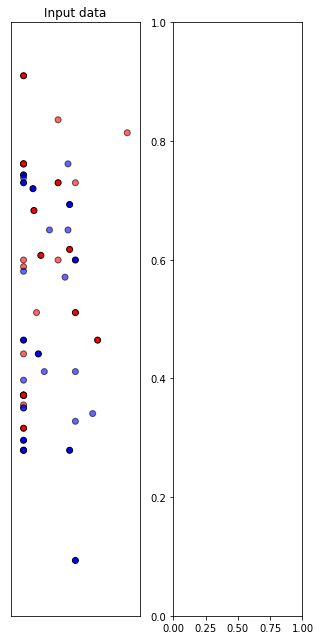

In [187]:
figure = plt.figure(figsize=(27, 9))
i = 1

# preprocess dataset, split into training and test part
# X = StandardScaler().fit_transform(X)
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    
    
    if hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]

    thresh = 0.5

    pred = []
    for v in y_score:
        if v > thresh:
            pred.append(1)
        else:
            pred.append(0)
    

    print(name)
    print("AUC: ", roc_auc_score(y_test, y_score))
    target_names = ['group 1', 'group 2']
    print(classification_report(y_test, pred, target_names=target_names))

plt.tight_layout()
plt.show()